# COMP90051 Project 2

In [8]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## read in data

In [9]:
file = open("dataset.txt","r")
data = file.readlines()
file.close()
arms = []
rewards = []
contexts = []
for event in data:
    event = event.split()
    arms.append(int(event[0])) # arm id, 1-10
    rewards.append(int(event[1])) # 0 or 1
    int_contexts = [int(i) for i in event[2:]]
    feature = []
    for i in range(10): # store contexts as 1 10*1 vector per arm
        feature.append(int_contexts[10*i:10*i+10])
    contexts.append(feature)

## 1. Implement ε-Greedy and UCB

In [10]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [6]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q_value = [Q0 for i in range(narms)]
        self.sum_reward = [0 for i in range(narms)]
        self.num_chosen = [0 for i in range(narms)]
        
    def play(self, tround, context):
        random_value = np.random.random() # control random move
        if random_value > self.epsilon: # has 1-epsilon probability to choose exploitation.
            # get all arm id with maximum q-value to make sure choose between them randomly.
            max_arm = []
            max_q = max(self.Q_value)
            for i in range(len(self.Q_value)):
                if self.Q_value[i] == max_q: # get all arms with largest value
                    max_arm.append(i+1) # store arm id instead of index. arm id: 1-10
            return int(np.random.choice(max_arm))
        else:
            return int(np.random.randint(1,self.narms+1)) # randint upperbound is exclusive, so +1 make sure choose from 1 to 10
        
    def update(self, arm, reward, context):
        self.num_chosen[arm-1] += 1
        N = self.num_chosen[arm-1]
        # record sum of reward also to avoid 0*inf during the calculation of average reward
        self.sum_reward[arm-1] = self.sum_reward[arm-1] + reward
        self.Q_value[arm-1] = self.sum_reward[arm-1]/N
        
    

In [11]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.sum_reward = [0 for i in range(narms)]
        self.num_chosen = [0 for i in range(narms)]
        self.value = [Q0 for i in range(narms)]
        
    
    def play(self, tround, context):
        self.t = tround  # read in number of arms
        max_q = max(self.value)
        max_arm = []
        for i in range(len(self.value)): # get all arms with largest value
            if self.value[i] == max_q:
                max_arm.append(i+1)
        return np.random.choice(max_arm) # randomly choose between value-maximizing arms
        
    def update(self, arm, reward, context):
        self.num_chosen[arm-1] += 1
        N = self.num_chosen[arm-1]
        # record sum of reward also to avoid 0*inf during the calculation of average reward
        self.sum_reward[arm-1] = self.sum_reward[arm-1] + reward
        self.value[arm-1] = self.sum_reward[arm-1]/N + np.sqrt((self.rho*np.log(self.t))/N)
    

## 2. Off-Policy Evaluation

In [12]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    history = []
    history_reward = []
    tround = 1
    for i in range(len(arms)):
        if tround > nrounds:
            break
        else:
            play_arm = mab.play(tround,contexts[i])
            if play_arm == arms[i]:
                tround += 1   # only update when play results match the log record
                mab.update(play_arm,rewards[i],contexts[i])
                history.append(play_arm) # record matched arms and rewards
                history_reward.append(rewards[i])
    return history_reward
    

In [13]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.2675


In [14]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16125


## 3. Contextual Bandits

In [15]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha): # ndims = 10
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.matrixA = {}
        self.vectorB = {}
        self.theta = {}
        # initialize for all arms
        for i in range(narms): # i:0-9  hence arm id is 1-10
            self.matrixA[i+1] = np.identity(ndims) # using arm id (1-10) directly as keys
            self.vectorB[i+1] = np.zeros((ndims,1))
            self.theta[i+1] = np.dot(np.linalg.inv(self.matrixA[i+1]),self.vectorB[i+1])
        
        
    def play(self, tround, context):
        p_value = []
        for i in range(self.narms):
            Xta = np.array(context[i]).reshape(-1,1) # feature matrix
            # calculate p value using stored theta, and update theta at update function
            p = np.dot(np.transpose(self.theta[i+1]),Xta) + self.alpha*np.sqrt(np.dot(np.dot(np.transpose(Xta),np.linalg.inv(self.matrixA[i+1])),Xta))
            p_value.append(p[0][0])
        max_p = max(p_value)
        max_arm = []
        for i in range(len(p_value)):
            if p_value[i] == max_p:
                max_arm.append(i+1)
        return np.random.choice(max_arm)
            
    
    def update(self, arm, reward, context):
        Xta = np.array(context[arm-1]).reshape(-1,1)
        self.matrixA[arm] = self.matrixA[arm] + np.dot(Xta,np.transpose(Xta))
        self.vectorB[arm] = self.vectorB[arm] + reward*Xta
        self.theta[arm] = np.dot(np.linalg.inv(self.matrixA[arm]),self.vectorB[arm]) # update theta for each new arm
        
        
    

In [16]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

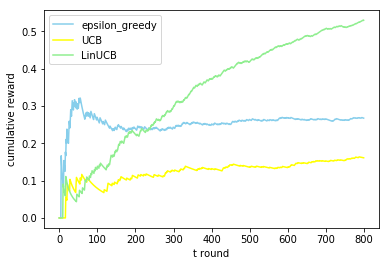

In [17]:
def cumulative_reward(results):
    cum_value = 0
    cum_list = []
    for i in range(len(results)):
        cum_value += results[i]
        cum_list.append(cum_value/(i+1))
    return cum_list

Y_greedy = cumulative_reward(results_EpsGreedy)
Y_UCB = cumulative_reward(results_UCB)
Y_LinUCB = cumulative_reward(results_LinUCB)

T = [i for i in range(len(Y_greedy))]

plt.plot(T, Y_greedy, color = "skyblue",label = "epsilon_greedy")
plt.plot(T, Y_UCB, color = "yellow", label = "UCB")
plt.plot(T, Y_LinUCB, color = "lightgreen", label = "LinUCB")
plt.xlabel("t round")
plt.ylabel("cumulative reward")
plt.legend()

### 4.B.

In [18]:
# using average rewards to tuning alpha
alter_alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
result_list = []
for alpha in alter_alpha:
    mab = LinUCB(10, 10, alpha)
    lin_reward = offlineEvaluate(mab, arms, rewards, contexts, 800)
    result_list.append(np.mean(lin_reward))
max_result = max(result_list)
best_alpha = alter_alpha[result_list.index(max_result)]
print ("best alpha is ", best_alpha)

best alpha is  0.1


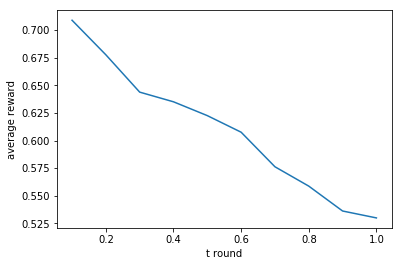

In [19]:
# showing in graph:
plt.plot(alter_alpha, result_list)
plt.xlabel("t round")
plt.ylabel("average reward")
plt.show()

Above result shows that the parameter is optimised when it closes to zero.

## 5. KernelUCB

In [11]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [12]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    

IndentationError: expected an indented block (<ipython-input-12-8163fcb89ddf>, line 25)